In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [19]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/energy_forecaster/inputs/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


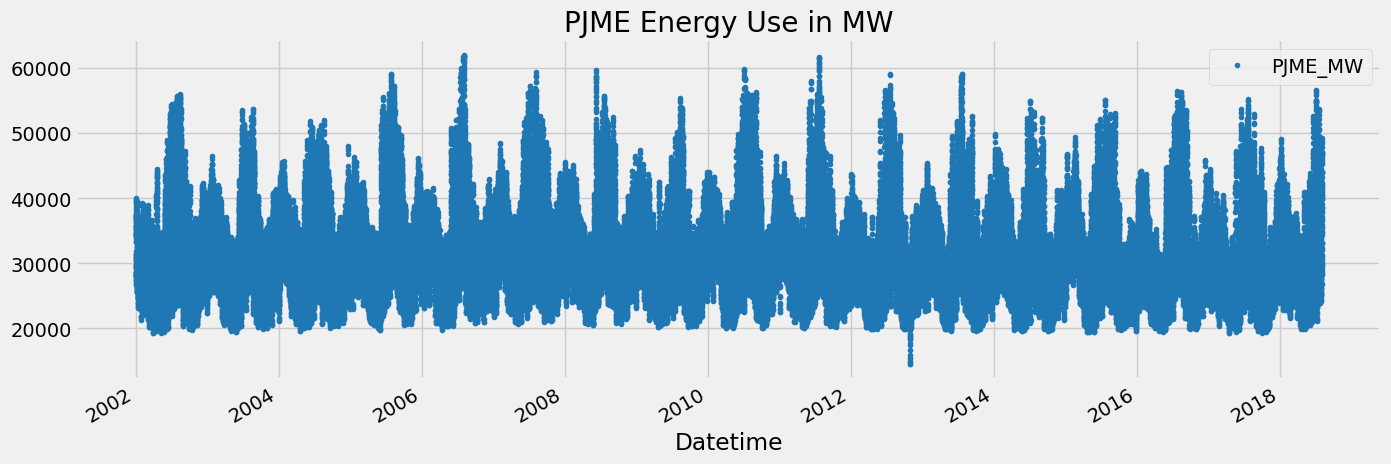

In [21]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

#Train test split

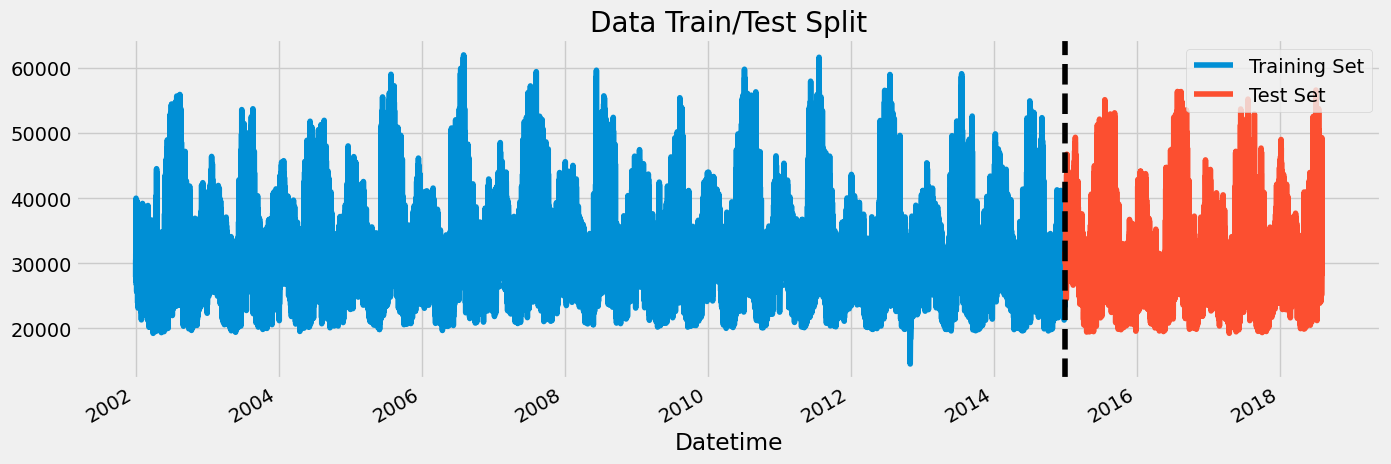

In [23]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Axes: xlabel='Datetime'>

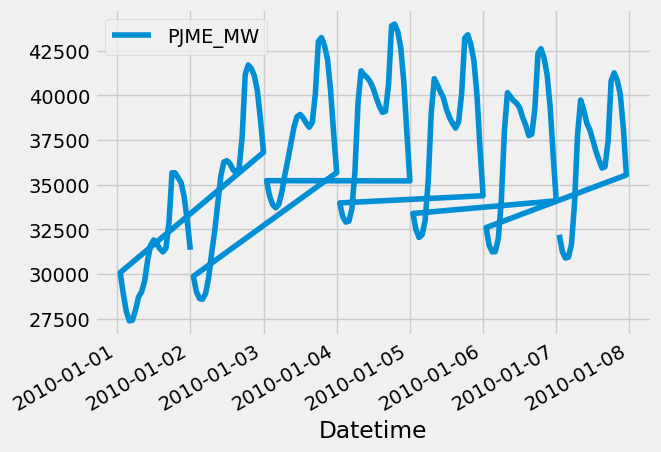

In [35]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot()

#Feature Creation

In [43]:
def create_features(df):

    df=df.copy()
    df['hour']= df.index.hour
    df['dayofweek']= df.index.day_of_week
    df['quarter']= df.index.quarter
    df['month']= df.index.month
    df['year']= df.index.year
    df['dayofyear']= df.index.day_of_year
    df['dayofmonth']= df.index.day
    df['weekofyear']= df.index.isocalendar().week
    return df

df=create_features(df)

Viz

<ipython-input-52-bceb963c392c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='PJME_MW', data=df, palette = 'Blues')


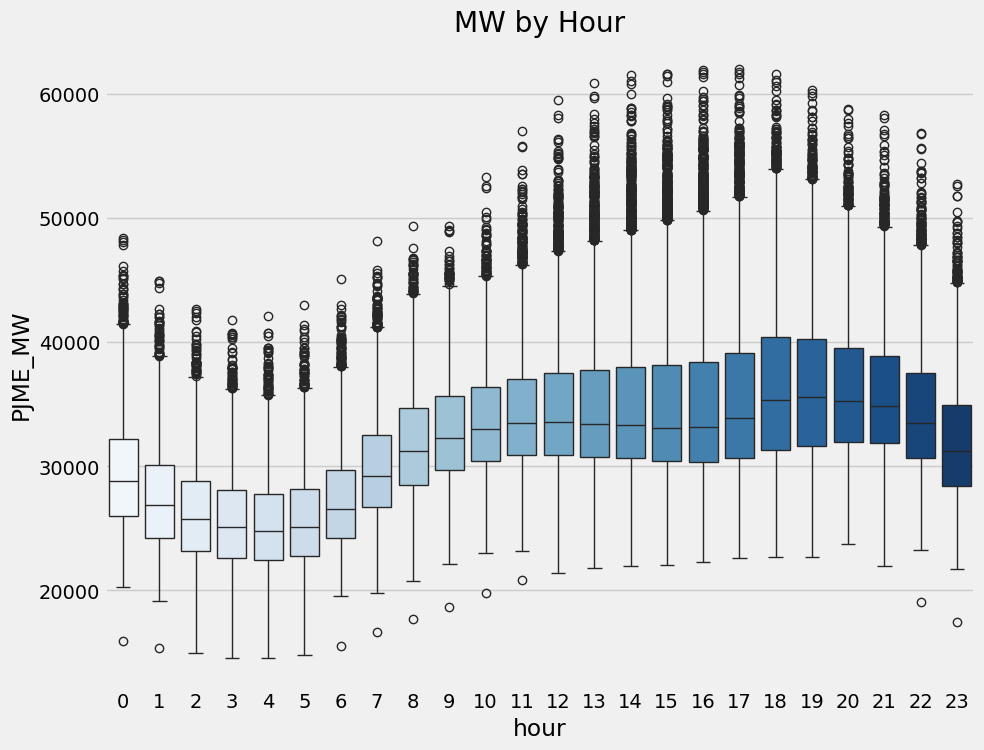

<ipython-input-52-bceb963c392c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='PJME_MW', data=df, palette = 'Greens')


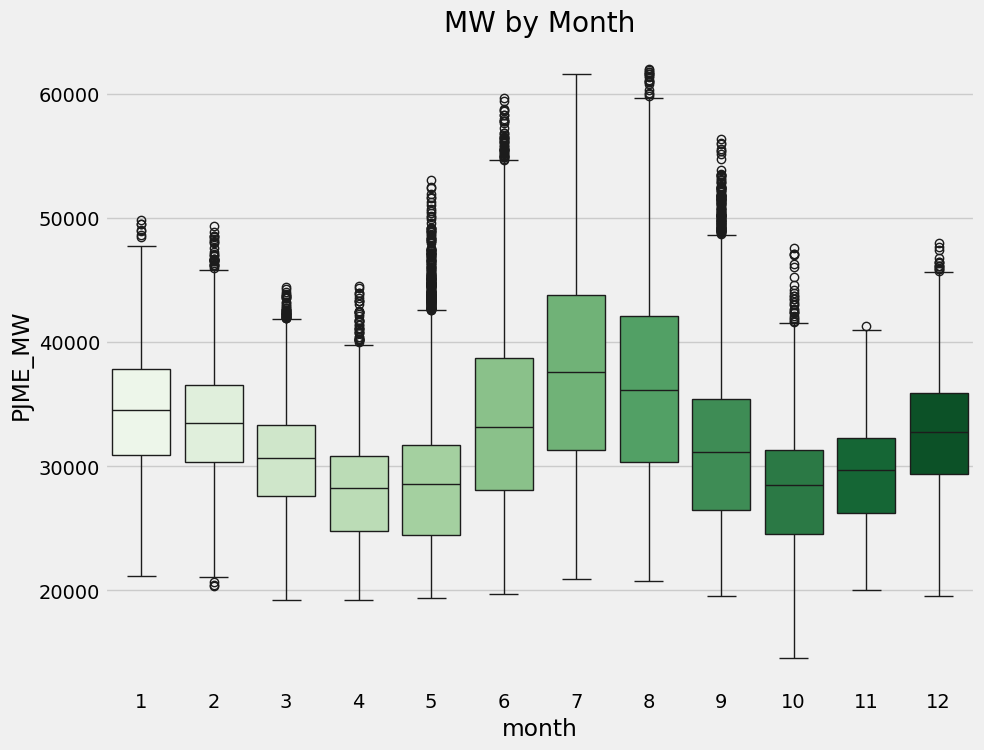

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='hour', y='PJME_MW', data=df, palette = 'Blues')
plt.title('MW by Hour')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='month', y='PJME_MW', data=df, palette = 'Greens')
plt.title('MW by Month')
plt.show()

# Model

In [54]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [56]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=250)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:41:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[250]	validation_0-rmse:4562.20070	validation_1-rmse:4372.53964
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[750]	validation_0-rmse:3133.02749	validation_1-rmse:3744.76096
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

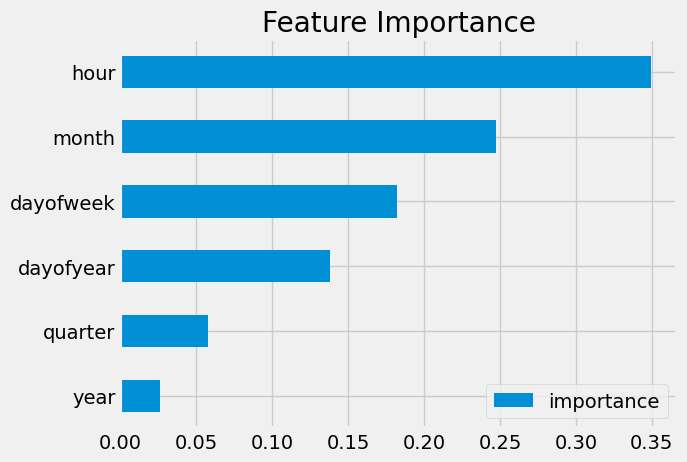

In [61]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance']).sort_values('importance')

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#Forecast on test set

In [63]:
test['prediction'] = reg.predict(X_test)

df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,37738.308594
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,37685.746094
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,36207.367188


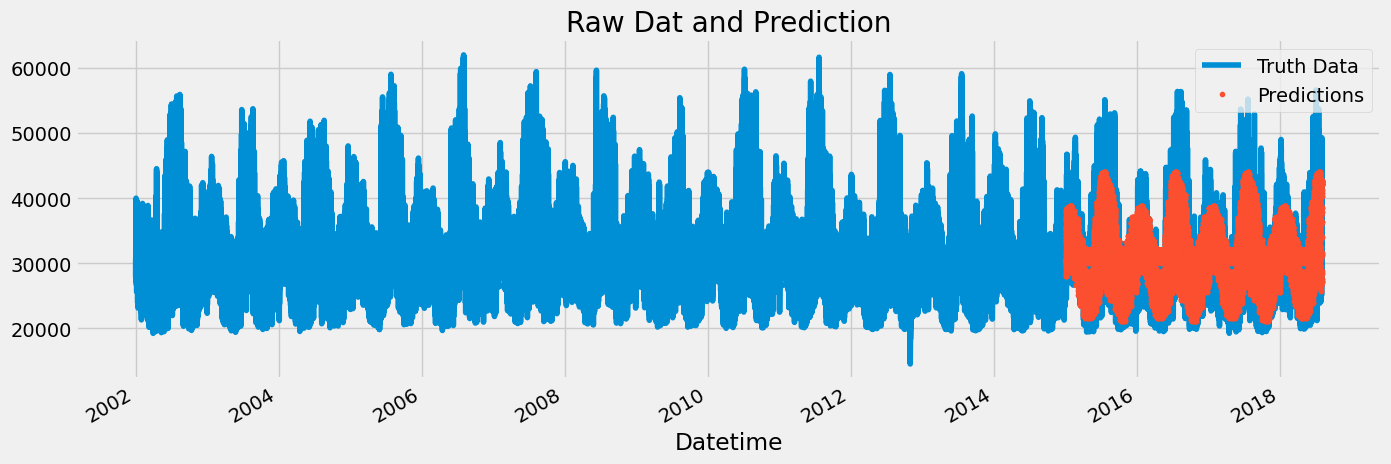

In [65]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

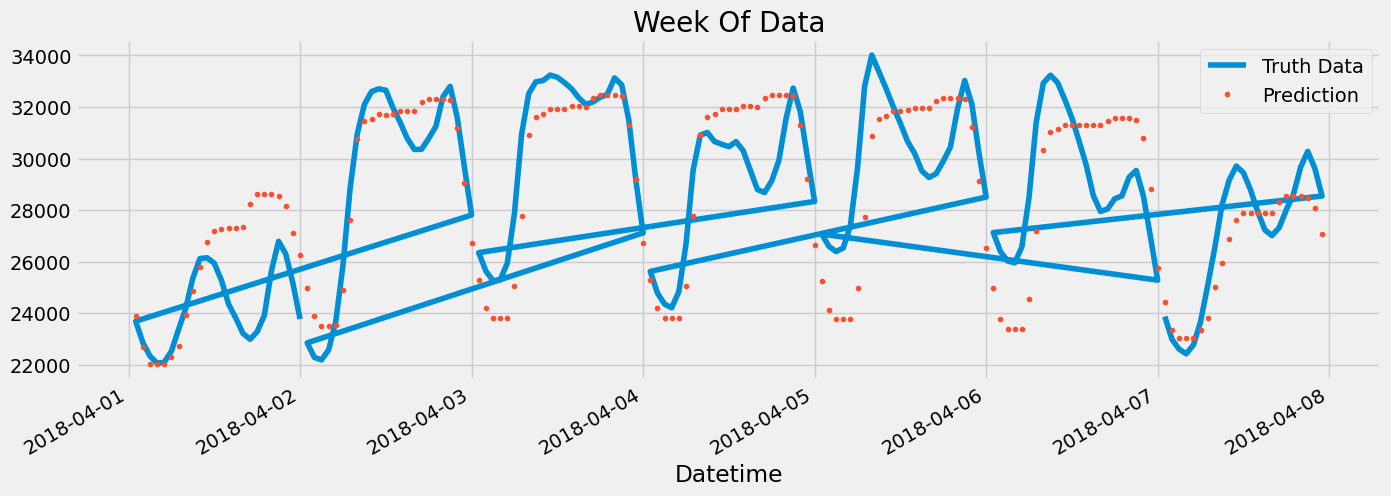

In [66]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [70]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


In [71]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

,error
date,
2016-08-13,12879.484619
2016-08-14,12772.887207
2015-02-20,11186.031494
2016-09-09,10966.513102
2016-09-10,10889.102214
2018-01-06,10642.975830
2016-08-12,10041.172689
2015-02-21,9988.168783
2015-02-16,9900.809326
